# CW2 - Machine/Deep learning algorithms in cryptocurrency trading

### Data set selection and definition of ML objective

**Objectives**:

1. Use machine/deep learning to predict important cryptocurrency trading parameters namely **price direction**, **volatility** and **price range**.

- **Price Direction**: Predicting whether the price will go up or down in a specified future time frame. This binary outcome (up/down) is often more practical and potentially more accurate than predicting exact future prices.

- **Volatility**: Forecasting the future volatility of a cryptocurrency can be useful for risk management and for strategies that are sensitive to price fluctuations.

- **Price Range**: Predicting the high and low prices for a future period can provide insights into expected price movements and help set stop-loss and take-profit levels.

2. Make predictions for the 5 most popular cryptocurrencies. **Bitcoin**, **Ethereum**, **Ripple**, **Litecoin** and **Monero**.

[Kaggle - Top 100 Cryptocurrencies Historical Dataset](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset/data)

In [371]:
# First lets set the path for Kaggle API
import os

kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_file = os.path.join(kaggle_dir, 'kaggle.json')

# Check if the .kaggle directory exists before creating it
if not os.path.exists(kaggle_dir):
    os.system("mkdir -p " + kaggle_dir)
    print("Created directory " + kaggle_dir)
else:
    print("Directory " + kaggle_dir + " already exists")

# Check if the kaggle.json file exists in the .kaggle directory before moving it
if not os.path.exists(kaggle_file):
    os.system("mv kaggle.json " + kaggle_file)
    os.system("chmod 600 " + kaggle_file)
    print(f"Moved kaggle.json to {kaggle_file} and changed its permissions")
else:
    print("File " + kaggle_file + " already exists, changing its permissions not needed")


# Check if the zip file exists before downloading
if not os.path.exists('top-10-cryptocurrencies-historical-dataset.zip'):
    !kaggle datasets download -d kaushiksuresh147/top-10-cryptocurrencies-historical-dataset
    !unzip top-10-cryptocurrencies-historical-dataset.zip
    print("Downloaded and unzipped top-10-cryptocurrencies-historical-dataset.zip")
else:
    print("File top-10-cryptocurrencies-historical-dataset.zip already exists")

Directory /home/realtime/.kaggle already exists
File /home/realtime/.kaggle/kaggle.json already exists, changing its permissions not needed
File top-10-cryptocurrencies-historical-dataset.zip already exists


### Data preparation and Analysis

In [372]:
# Loading the data into dataframes
import pandas as pd

# List of cryptocurrencies
cryptos = ['bitcoin', 'litecoin', 'ethereum', 'monero', 'xrp']

# Dictionary to store the dataframes
dfs = {}

# Load each CSV file into a DataFrame and store it in the dictionary
for crypto in cryptos:
    df_name = 'raw_' + crypto + '_pd'
    dfs[df_name] = pd.read_csv(f'Top 100 Crypto Coins/{crypto}.csv')
    print(f"Top 5 rows of {df_name}:")
    print(dfs[df_name].head())
    print("\n")

    print(f"Statistics for {df_name}:")
    print(dfs[df_name].describe())
    print("\n")
    
    print(f"Missing values in {df_name}:")
    print(dfs[df_name].isnull().sum())
    print("\n")


Top 5 rows of raw_bitcoin_pd:
         Date  Open  High  Low  Close  Volume Currency
0  2010-07-18   0.0   0.1  0.1    0.1      75      USD
1  2010-07-19   0.1   0.1  0.1    0.1     574      USD
2  2010-07-20   0.1   0.1  0.1    0.1     262      USD
3  2010-07-21   0.1   0.1  0.1    0.1     575      USD
4  2010-07-22   0.1   0.1  0.1    0.1    2160      USD


Statistics for raw_bitcoin_pd:
               Open          High           Low         Close        Volume
count   4420.000000   4420.000000   4420.000000   4420.000000  4.420000e+03
mean    8302.221855   8531.971380   8043.473869   8306.969457  1.395788e+07
std    14598.398937  14992.605971  14146.499234  14599.046649  1.645973e+08
min        0.000000      0.100000      0.000000      0.100000  0.000000e+00
25%      122.500000    129.975000    118.300000    122.800000  3.013600e+04
50%      683.600000    706.500000    657.550000    685.000000  6.762050e+04
75%     8877.250000   9122.700000   8666.900000   8886.075000  1.769402e+05

In [373]:
import plotly.graph_objects as go

# Get the DataFrame for Bitcoin
df_bitcoin = dfs['raw_bitcoin_pd']

# Create a candlestick plot
fig = go.Figure(data=[go.Candlestick(x=df_bitcoin['Date'],
                open=df_bitcoin['Open'],
                high=df_bitcoin['High'],
                low=df_bitcoin['Low'],
                close=df_bitcoin['Close'])])

# Set the title and axis labels
fig.update_layout(
    title='Bitcoin Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price(USD)',
)

# Show the plot
fig.show()

In [374]:
# Let's analyse Bitcoin's price for t

df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date'])

# Get the date one year ago from the latest date in the DataFrame
one_year_ago = df_bitcoin['Date'].max() - pd.DateOffset(years=1)

# Filter the DataFrame to include only the data from the last year
df_bitcoin_last_year = df_bitcoin[df_bitcoin['Date'] >= one_year_ago]

# Create a candlestick plot for the last year's worth of data
fig = go.Figure(data=[go.Candlestick(x=df_bitcoin_last_year['Date'],
                open=df_bitcoin_last_year['Open'],
                high=df_bitcoin_last_year['High'],
                low=df_bitcoin_last_year['Low'],
                close=df_bitcoin_last_year['Close'])])

# Set the title and axis labels
fig.update_layout(
    title='Bitcoin Candlestick Chart (Last Year)',
    xaxis_title='Date',
    yaxis_title='Price(USD)',
)

# Show the plot
fig.show()

In [375]:
import ta
import plotly.subplots as sp

# Calculate the moving average for the last 14 days
df_bitcoin['MA'] = ta.trend.sma_indicator(df_bitcoin['Close'], window=14)

# Calculate the RSI for the last 14 days
df_bitcoin['RSI'] = ta.momentum.rsi(df_bitcoin['Close'], window=14)

# Get the date 14 days ago from the latest date in the DataFrame
fourteen_days_ago = df_bitcoin['Date'].max() - pd.DateOffset(days=14)

# Filter the DataFrame to include only the data from the last 14 days
df_bitcoin_last_14_days = df_bitcoin[df_bitcoin['Date'] >= fourteen_days_ago]

# Create a subplot figure
fig = sp.make_subplots(rows=2, cols=1, shared_xaxes=False, 
                       subplot_titles=('Moving Average', 'RSI'), 
                       vertical_spacing=0.3, 
                       specs=[[{"secondary_y": True}], [{"secondary_y": True}]])

# Add the moving average trace
fig.add_trace(go.Scatter(x=df_bitcoin_last_14_days['Date'], 
                         y=df_bitcoin_last_14_days['MA'], 
                         mode='lines', 
                         name='Moving Average'), 
              row=1, col=1)

# Add the RSI trace
fig.add_trace(go.Scatter(x=df_bitcoin_last_14_days['Date'], 
                         y=df_bitcoin_last_14_days['RSI'], 
                         mode='lines', 
                         name='RSI'), 
              row=2, col=1)

# Add x-axis labels
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)

# Add y-axis labels
fig.update_yaxes(title_text="USD", row=1, col=1)
fig.update_yaxes(title_text="RSI", row=2, col=1)

# Update the layout to increase the size of the plot
fig.update_layout(height=800, width=1200, title = "Bitcoin Moving Average and RSI (Last 14 Days)")


# Show the plot
fig.show()

### Model Selection and Training

In [376]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_shifted_price(df, shift_days, last_n_days=14):
    """
    Plots the closing price and the shifted closing price for the last 'n' days.

    Parameters:
    df (pandas.DataFrame): The data frame containing the 'Close' and 'Prediction' columns.
    shift_days (int): The number of days the 'Prediction' column is shifted.
    last_n_days (int): The number of last days to plot. Default is 14.
    """
    # Get the last 'n' days
    last_days = df[-last_n_days:]

    # Plot the closing prices and the shifted closing prices
    plt.figure(figsize=(10, 6))
    plt.plot(last_days.index, last_days['Close'], 'blue', label='Closing Price')
    plt.plot(last_days.index, last_days['Prediction'], 'red', label=f'{shift_days} days shifted closing price')

    # Format the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

    # Set the labels and title
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.title('Bitcoin Closing Price vs Shifted Closing Price')

    # Show the legend
    plt.legend()

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

In [377]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

def predict_and_plot(df, days_to_predict):
    # Create a variable for predicting 'n' days out into the future
    projection = days_to_predict

    df.set_index('Date', inplace=True)

    # Create a new column with a name prediction
    df['Prediction'] = df[['Close']].shift(-projection)

    # Create the independent data set (X)
    X = np.array(df[['Close']])
    X = X[:-projection]

    # Create the dependent data set (y)
    y = np.array(df['Prediction'])
    y = y[:-projection]

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create & train the model
    linReg = LinearRegression()
    linReg.fit(x_train, y_train)

    # Create the independent data set for the projection
    x_projection = np.array(df[['Close']])[-projection:]

    # Use the model to make predictions for the next 'n' days
    linReg_prediction = linReg.predict(x_projection.reshape(-1, 1))

    # Get the last 'n' days of closing price data and predicted price
    recent_days = df.index[-days_to_predict:]
    recent_close_price = df['Close'][-days_to_predict:]
    predicted_price = linReg_prediction

    # Create a new DataFrame for plotting
    plot_df = df.loc[recent_days]

    # Add the predicted price to the DataFrame
    plot_df['Predicted'] = np.append([np.nan for _ in range(len(recent_days) - len(predicted_price))], predicted_price)

    print(f"Actual price:\n {plot_df['Close']}\nPredicted price:\n {plot_df['Predicted']}")

    # Plot the actual close price and predicted price
    plt.figure(figsize=(10,5))
    plt.scatter(plot_df.index, plot_df['Close'], label='Actual Price')
    plt.scatter(plot_df.index, plot_df['Predicted'], label='Predicted Price')

    # Add lines between the scatter dots
    plt.plot(plot_df.index, plot_df['Close'], color='blue')
    plt.plot(plot_df.index, plot_df['Predicted'], color='orange')

    # Highlight the area between the predicted and actual price
    plt.fill_between(plot_df.index, plot_df['Close'], plot_df['Predicted'], color='skyblue', alpha=0.3)

    # Set the title and labels
    plt.title(f'Bitcoin Price Prediction for {days_to_predict} days')
    plt.xlabel('Date')
    plt.ylabel('Price(USD)')
    plt.legend()

    # Improve date formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    # Rotate date labels to prevent overlap
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.show()

    # Create a new DataFrame for future predictions
    future_df = pd.DataFrame()
    last_day_price = df['Close'].tail(1).values

    for i in range(days_to_predict):
        future_prediction = linReg.predict(last_day_price.reshape(-1, 1))
        future_df = future_df.append(pd.DataFrame({'Predicted': future_prediction}, index=[df.index[-1] + timedelta(days=i+1)]))
        last_day_price = future_prediction  # Update last_day_price with the predicted value

    print(f"Future predcitions:\n {future_df['Predicted']}")

    # Plot the predicted price for the next 'n' days
    plt.figure(figsize=(10,5))
    plt.scatter(future_df.index, future_df['Predicted'], label='Predicted Price')

    # Add lines between the scatter dots
    plt.plot(future_df.index, future_df['Predicted'], color='orange')

    # Set the title and labels
    plt.title(f'Bitcoin Future Price Prediction for {days_to_predict} days')
    plt.xlabel('Date')
    plt.ylabel('Price(USD)')
    plt.legend()

    # Improve date formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    # Rotate date labels to prevent overlap
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.show()

Actual price:
 Date
2022-08-19    20831.3
2022-08-20    21138.9
2022-08-21    21517.2
2022-08-22    21416.3
2022-08-23    21309.0
Name: Close, dtype: float64
Predicted price:
 Date
2022-08-19    20762.132942
2022-08-20    21067.641627
2022-08-21    21443.369637
2022-08-22    21343.155637
2022-08-23    21236.585149
Name: Predicted, dtype: float64


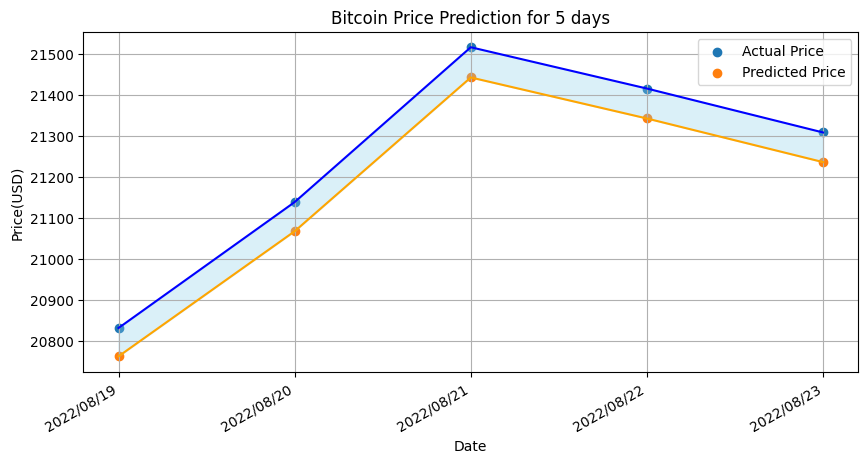

Future predcitions:
 2022-08-24    21236.585149
2022-08-25    21164.662634
2022-08-26    21093.229106
2022-08-27    21022.281241
2022-08-28    20951.815738
Name: Predicted, dtype: float64


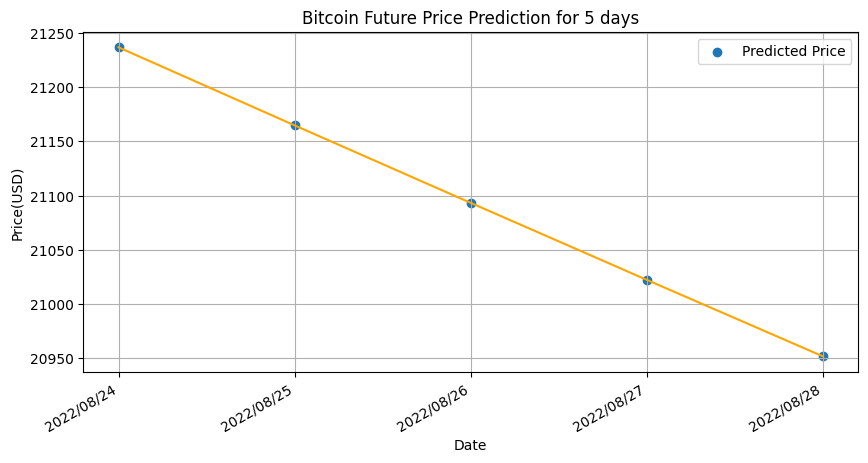

In [378]:
predict_and_plot(df_bitcoin, 5)